
Analyzing file: test_a.wav

*** WARNING: High Sampling Rate Detected! ***
The input file has Fs=44100 Hz. For accurate formant analysis, please downsample the file to 16000 Hz.
Loaded signal with sampling rate: 44100 Hz. Total frames: 159

Estimated Formant Frequencies (Hz): []


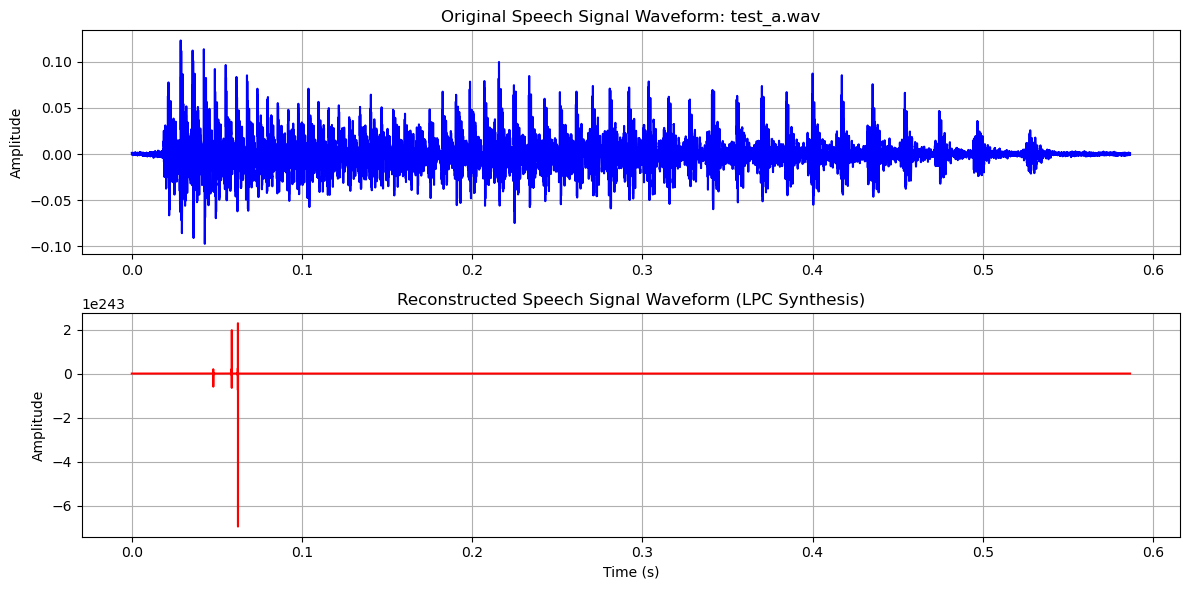

C:\Users\Joel\AppData\Local\Temp\ipykernel_29360\254851941.py:250: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


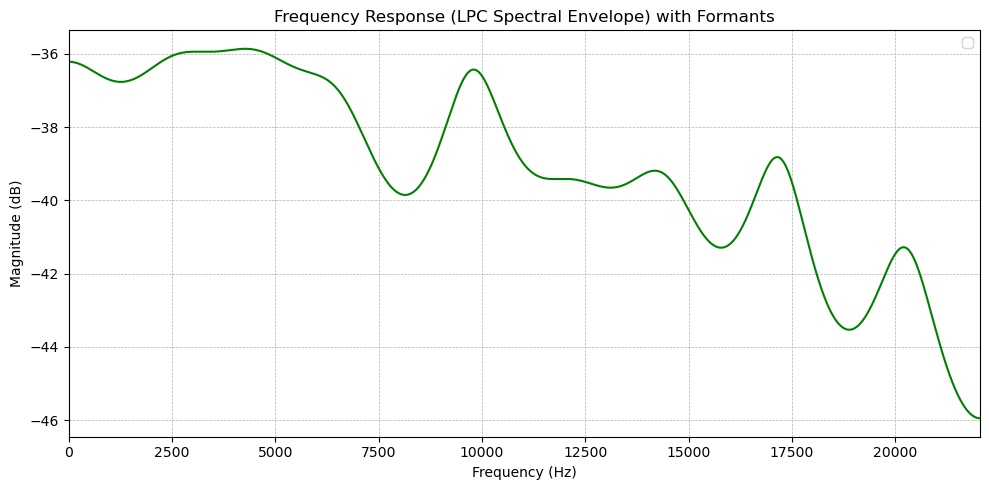


--- Comparison of Estimated Formants with Standard Vowel Data ---
Not enough formants (F1, F2) were estimated for a proper comparison. Please ensure your input file is a clean, sustained vowel sampled at approximately 16000 Hz.

Successfully saved reconstructed signal to: test_a_reconstructed.wav


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import lfilter, freqz
from scipy.signal.windows import hamming
from scipy.linalg import solve
import os
import sys

# --- 1. Standard Vowel Formant Data ---
VOWEL_FORMANT_DATA = {
    # Vowel (IPA): [F1 (Hz), F2 (Hz)]
    'i': [240, 2400],
    'y': [235, 2100],
    'e': [390, 2300],
    'ø': [370, 1900],
    'ɛ': [610, 1900],
    'œ': [585, 1710],
    'a': [850, 1610],
    'æ': [820, 1530],
    'ɑ': [750, 940],
    'ɒ': [700, 760],
    'ʌ': [600, 1170],
    'ɔ': [500, 700],
    'ɤ': [460, 1310],
    'o': [360, 640],
    'ɯ': [300, 1390],
    'u': [250, 595]
}

# --- 2. Configuration Parameters ---
# STANDARD PARAMETERS FOR 16 kHz SPEECH ANALYSIS
LPC_ORDER = 18 # Ideal order for 16 kHz (16/1 + 2 = 18)
FRAME_SIZE = 512
HOP_SIZE = 160 
STABILITY_GAMMA = 0.999 # Standard stability factor is now sufficient for P=18

# --- 3. Speech Signal Acquisition and Framing ---
def load_and_frame_signal(file_path):
    """Loads a WAV file and splits it into overlapping frames."""
    
    signal, fs = sf.read(file_path)
    
    if fs > 20000:
        print("\n*** WARNING: High Sampling Rate Detected! ***")
        print(f"The input file has Fs={fs} Hz. For accurate formant analysis, please downsample the file to 16000 Hz.")
        
    if signal.ndim > 1:
        signal = signal[:, 0]
    
    # Pre-emphasis filter: H(z) = 1 - 0.97z^-1
    signal = lfilter([1, -0.97], [1], signal)
    
    num_samples = len(signal)
    num_frames = 1 + int(np.floor((num_samples - FRAME_SIZE) / HOP_SIZE))
    
    frames = []
    for i in range(num_frames):
        start = i * HOP_SIZE
        end = start + FRAME_SIZE
        # Apply Hamming window
        frame = signal[start:end] * hamming(FRAME_SIZE)
        frames.append(frame)
        
    return signal, fs, frames, num_frames

# --- 4. LPC Analysis (Autocorrelation Method with Stabilization) ---
def lpc_analysis(frame, order, gamma):
    """
    Computes LPC coefficients and gain using Levinson-Durbin with 
    Bandwidth Expansion (gamma) for filter stability.
    """
    R = np.correlate(frame, frame, mode='full')[len(frame) - 1 :]
    R = R[: order + 1]
    
    # Bandwidth Expansion for Stability: R[i] = R[i] * gamma**i
    if gamma != 1.0:
        for i in range(1, order + 1):
            R[i] = R[i] * (gamma ** i)
            
    a = np.zeros(order + 1)
    a[0] = 1.0
    E = R[0]
    
    # Levinson-Durbin Recursion
    for m in range(1, order + 1):
        k = R[m]
        for i in range(1, m):
            k -= a[i] * R[m - i]
        
        if E == 0:
            k = 0
        else:
            k /= E
            
        a_new = np.zeros(order + 1)
        a_new[0] = 1.0
        a_new[m] = k
        for i in range(1, m):
            a_new[i] = a[i] - k * a[m - i]
            
        a = a_new
        E *= (1 - k**2)
    
    G = np.sqrt(E) if E > 0 else 0
    return a, G

# --- 5. Signal Reconstruction ---
def reconstruct_signal(frames, lpc_coefficients_list, G_list, num_samples):
    """Reconstructs the entire speech signal from frame-wise LPC coefficients."""
    reconstructed_signal = np.zeros(num_samples)
    
    for i in range(len(frames)):
        start = i * HOP_SIZE
        end = start + FRAME_SIZE
        
        a = lpc_coefficients_list[i]
        G = G_list[i]
        
        # Excitation: Using scaled random noise
        excitation = np.random.normal(0, G, FRAME_SIZE)
        
        # Synthesis filter: H(z) = G / A(z). 
        reconstructed_frame = lfilter([G], a, excitation)
        
        # Overlap-add
        reconstructed_signal[start:end] += reconstructed_frame 
        
    return reconstructed_signal

# --- 6. Formant Estimation ---
def estimate_formants(a, fs):
    """Estimates formant frequencies from the roots of the LPC polynomial A(z)."""
    roots = np.roots(a)
    poles = roots[np.imag(roots) > 0] 
    
    formants_hz = np.arctan2(np.imag(poles), np.real(poles)) * fs / (2 * np.pi)
    bandwidths_hz = -np.log(np.abs(poles)) * fs / np.pi
    
    formants = sorted([(F, B) for F, B in zip(formants_hz, bandwidths_hz)], key=lambda x: x[0])
    
    # Final Relaxed Filter: Bandwidth limit set to 1000 Hz 
    meaningful_formants = [(F, B) for F, B in formants if F < fs/2 and B < 1000 and F > 90]
    
    return [f[0] for f in meaningful_formants]

# --- 7. Main Execution and Visualization ---
def run_lpc_analysis_lab():
    
    # --- Flexible File Acquisition Loop ---
    file_path = None
    while file_path is None:
        user_input = input("\nEnter the path to your WAV file (ideally downsampled to 16000 Hz): ").strip()
        
        if not user_input.lower().endswith('.wav'):
            print("Error: The file must be a '.wav' file. Please ensure the extension is correct.")
            continue
            
        if os.path.exists(user_input):
            file_path = user_input
            break
            
        directory = os.path.dirname(user_input)
        filename = os.path.basename(user_input)
        
        found_case_insensitive = False
        if os.path.isdir(directory) or directory == '':
            check_dir = directory if directory else '.'
            try:
                for item in os.listdir(check_dir):
                    if item.lower() == filename.lower():
                        file_path = os.path.join(check_dir, item)
                        found_case_insensitive = True
                        print(f"File found! Using path: {file_path}")
                        break
            except FileNotFoundError:
                pass
        
        if found_case_insensitive:
            break
        
        print(f"Error: File not found at '{user_input}'. Check the path and file name.")

    print(f"\nAnalyzing file: {file_path}")
    
    try:
        original_signal, fs, frames, num_frames = load_and_frame_signal(file_path)
    except Exception as e:
        print(f"Fatal Error during signal loading: {e}")
        return
        
    print(f"Loaded signal with sampling rate: {fs} Hz. Total frames: {num_frames}")
    
    # --- LPC Analysis and Reconstruction ---
    lpc_coeffs_list = []
    G_list = []
    
    for frame in frames:
        a, G = lpc_analysis(frame, LPC_ORDER, gamma=STABILITY_GAMMA) 
        lpc_coeffs_list.append(a)
        G_list.append(G)
        
    avg_lpc_coeffs = np.mean(lpc_coeffs_list, axis=0)
    avg_G = np.mean(G_list)

    reconstructed_signal = reconstruct_signal(frames, lpc_coeffs_list, G_list, len(original_signal))
    
    # --- Formant Estimation ---
    estimated_formants = estimate_formants(avg_lpc_coeffs, fs)
    print(f"\nEstimated Formant Frequencies (Hz): {estimated_formants}")
    
    # --- Visualization ---
    # Plot 1: Original and Reconstructed Signals (Saving to file)
    plt.figure(figsize=(12, 6))
    time_axis = np.linspace(0, len(original_signal) / fs, len(original_signal))
    
    plt.subplot(2, 1, 1)
    plt.plot(time_axis, original_signal, color='blue')
    plt.title(f'Original Speech Signal Waveform: {os.path.basename(file_path)}')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(time_axis, reconstructed_signal, color='red')
    plt.title('Reconstructed Speech Signal Waveform (LPC Synthesis)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('waveform_comparison.png')
    plt.show() # Display plot
    
    # Plot 2: Formant Frequencies (Frequency Response) (Saving to file)
    plt.figure(figsize=(10, 5))
    
    w, h = freqz(avg_G, avg_lpc_coeffs, worN=2048, fs=fs)
    
    plt.plot(w, 20 * np.log10(abs(h)), color='green')
    
    for i, F in enumerate(estimated_formants):
        label = f'Estimated F{i+1}'
        plt.axvline(F, color='red', linestyle='--', linewidth=1, label=label if i < 3 else None)
        
    plt.title('Frequency Response (LPC Spectral Envelope) with Formants')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.xlim(0, fs / 2)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig('spectral_envelope.png')
    plt.show() # Display plot
    
    # --- Comparison Table ---
    print("\n--- Comparison of Estimated Formants with Standard Vowel Data ---")
    
    if len(estimated_formants) >= 2:
        est_F1 = estimated_formants[0]
        est_F2 = estimated_formants[1]
        
        best_match_vowel = None
        min_distance = float('inf')
        
        for vowel, data in VOWEL_FORMANT_DATA.items():
            expected_F1 = data[0]
            expected_F2 = data[1]
            
            distance = np.sqrt((est_F1 - expected_F1)**2 + (est_F2 - expected_F2)**2)
            
            if distance < min_distance:
                min_distance = distance
                best_match_vowel = vowel
                
        
        print(f"\nEstimated F1: {est_F1:.2f} Hz | Estimated F2: {est_F2:.2f} Hz")
        print(f"Closest Standard Vowel Match: /{best_match_vowel}/ (Distance: {min_distance:.2f} Hz)")

        print("\n| Vowel (IPA) | Expected F1 (Hz) | Expected F2 (Hz) |")
        print("|-------------|------------------|------------------|")
        
        sorted_vowels = sorted(VOWEL_FORMANT_DATA.items(), key=lambda x: x[1][0])
        for vowel, data in sorted_vowels:
            print(f"| {vowel:11} | {data[0]:16.0f} | {data[1]:16.0f} |")
            
        print("|-------------|------------------|------------------|")
        print(f"| {'Estimated':11} | {est_F1:16.2f} | {est_F2:16.2f} | <-- Your Result")
    else:
        print("Not enough formants (F1, F2) were estimated for a proper comparison. Please ensure your input file is a clean, sustained vowel sampled at approximately 16000 Hz.")

    # --- 8. Save Reconstructed Signal to a WAV file ---
    output_filename = os.path.splitext(os.path.basename(file_path))[0] + "_reconstructed.wav"
    
    try:
        max_original_amp = np.max(np.abs(original_signal))
        max_reco_amp = np.max(np.abs(reconstructed_signal))
        
        if max_reco_amp > 0:
            scaled_reconstructed_signal = reconstructed_signal / max_reco_amp * max_original_amp
        else:
            scaled_reconstructed_signal = reconstructed_signal
            
        sf.write(output_filename, scaled_reconstructed_signal, fs)
        print(f"\nSuccessfully saved reconstructed signal to: {output_filename}")
        
    except Exception as e:
        print(f"\nError saving reconstructed file: {e}")


# --- Run the Lab ---
if __name__ == "__main__":
    run_lpc_analysis_lab()